In [1]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 9.0 MB 44.1 MB/s 
     |████████████████████████████████| 139 kB 57.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.10 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import boto3
import cv2 as cv
from google.colab.patches import cv2_imshow


In [4]:
import tensorflow as tf
from tensorflow import keras
# from keras.applications import VGG16, imagenet_utils
from keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

from imutils import paths
import numpy as np
import argparse
import random
import os
import progressbar


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
model = keras.applications.VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
from sample_data.functions import download_data

In [8]:
def download_data(quantity='all'):

    # setup a AWS S3 client/resource
    s3 = boto3.resource(
        's3', 
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        )

    # point the resource at the existing bucket
    bucket = s3.Bucket('anyoneai-datasets')
    if quantity == 'all':
        for file in bucket.objects.filter(Prefix = 'shot-type/movie-shot-trailers'):
            # ['shot-type', 'movie-shot-trailers', 'trailer', 'tt0444850', 'shot_0016.mp4']
            if 'shot_' in file.key:
                path = os.path.join(file.key.split('/')[1], file.key.split('/')[2], file.key.split('/')[3])
                full_path = os.path.join(path, file.key.split('/')[4])
                if not os.path.exists(path):
                    os.makedirs(path)
                if not os.path.exists(full_path):
                    with open(full_path, 'wb') as data:
                        bucket.download_fileobj(file.key, data)
            else:
                if not os.path.exists('movie-shot-trailers/extras'):
                    os.makedirs('movie-shot-trailers/extras')
                with open(f'movie-shot-trailers/extras/{os.path.split(file.key)[1]} ', 'wb') as data:
                    bucket.download_fileobj(file.key, data)
    else:
        i = 0
        for file in bucket.objects.filter(Prefix = 'shot-type/movie-shot-trailers'):
            i += 1
            if i == quantity:
                break
            if 'shot_' in file.key:
                path = os.path.join(file.key.split('/')[1], file.key.split('/')[2], file.key.split('/')[3])
                full_path = os.path.join(path, file.key.split('/')[4])
                if not os.path.exists(path):
                    os.makedirs(path)
                if not os.path.exists(full_path):
                    with open(full_path, 'wb') as data:
                        bucket.download_fileobj(file.key, data)
            else:
                if not os.path.exists('movie-shot-trailers/extras'):
                    os.makedirs('movie-shot-trailers/extras')
                with open(f'movie-shot-trailers/extras/{os.path.split(file.key)[1]} ', 'wb') as data:
                    bucket.download_fileobj(file.key, data)

In [ ]:
!sudo rm -R data/

In [9]:
download_data(30)

In [11]:
!sudo python3 sample_data/train_val_test_spliter.py -n movie-shot-trailers/extras/v1_split_trailer.txt -l True

Traceback (most recent call last):
  File "sample_data/train_val_test_spliter.py", line 77, in <module>
    train_val_test_split(split_json, labeled)
  File "sample_data/train_val_test_spliter.py", line 71, in train_val_test_split
    link_shot(split, labeled, part, trailer, shot)
  File "sample_data/train_val_test_spliter.py", line 63, in link_shot
    os.link(file_src_path,file_dst_path)
FileNotFoundError: [Errno 2] No such file or directory: 'movie-shot-trailers/trailer/tt2006802/shot_0011.mp4' -> 'data/Videos/train/tt2006802/shot_0011_MS:Static.mp4'


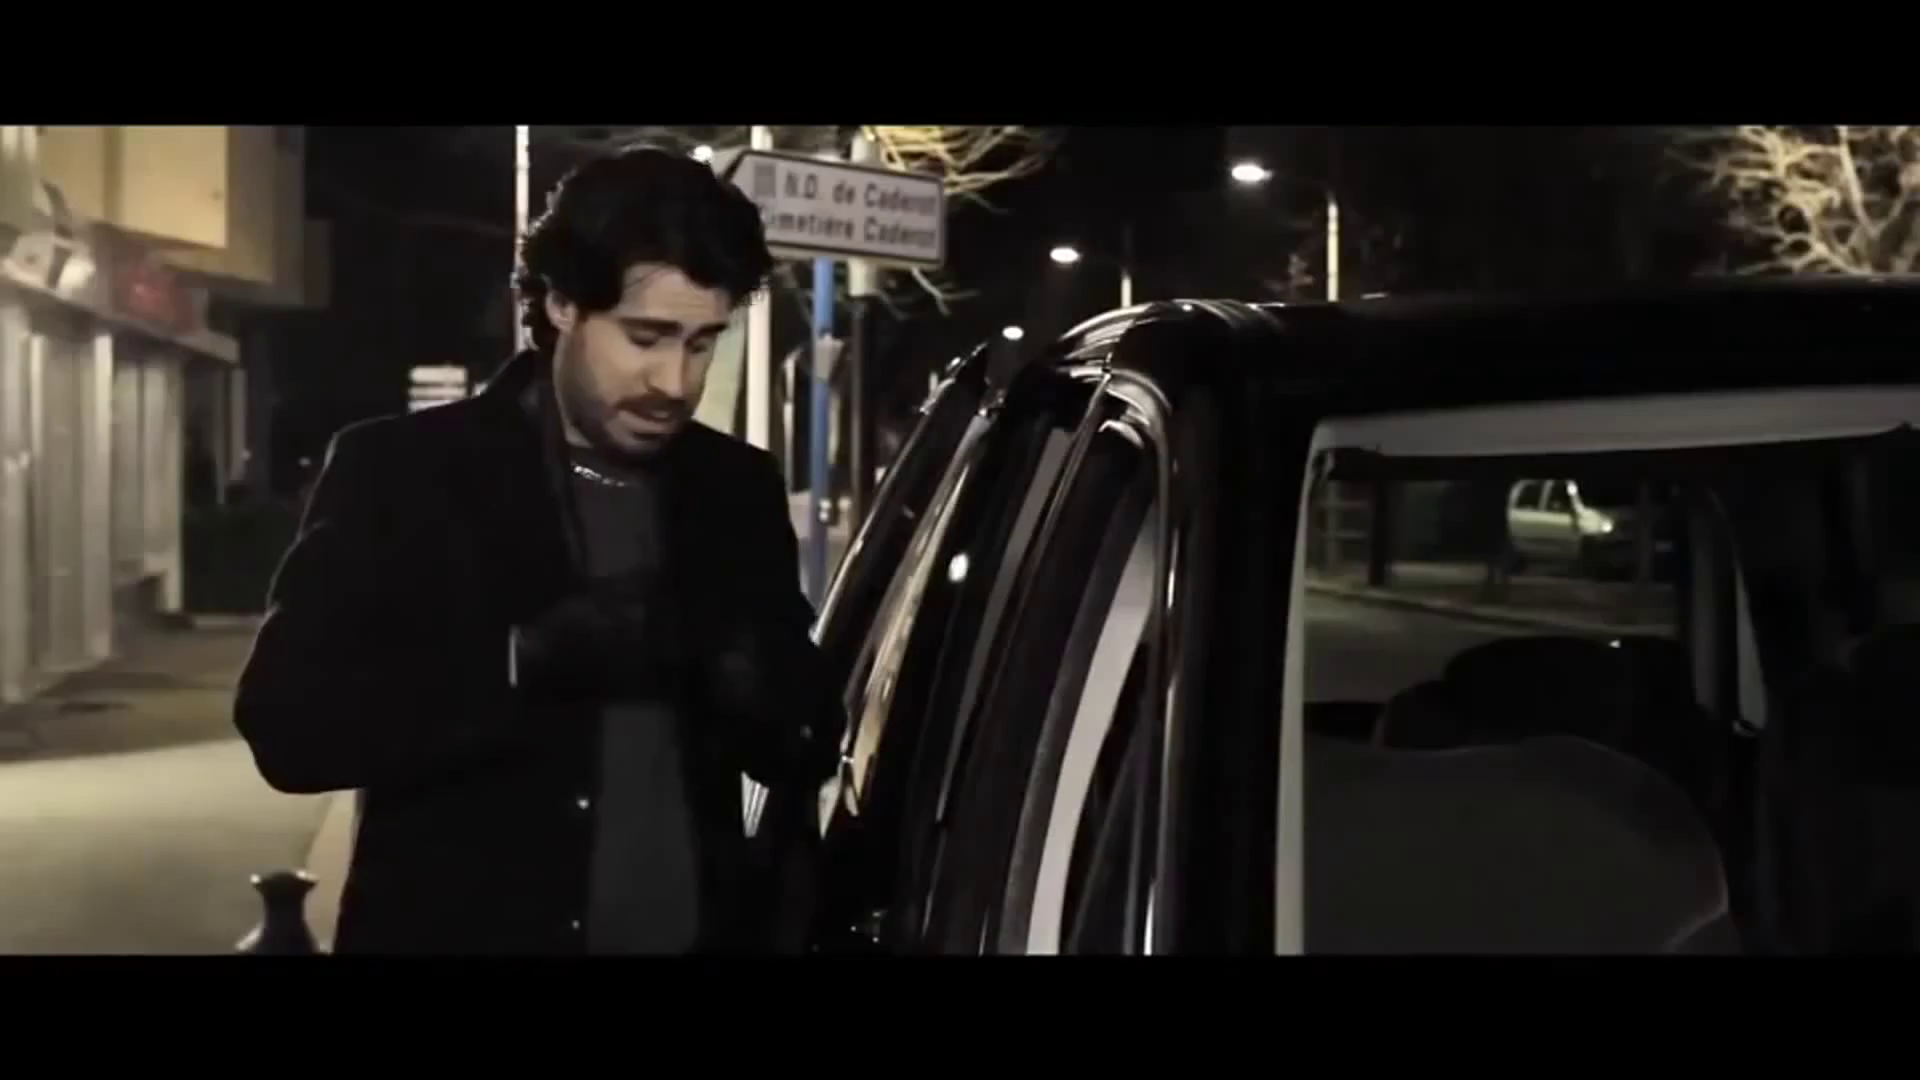

In [12]:
cap = cv.VideoCapture('data/Videos/train/tt2005173/shot_0022_MS:Static.mp4')
success, frame = cap.read()
cv2_imshow(frame)

In [ ]:
cap = cv.VideoCapture('data/Videos/train/tt2005185/shot_0014_MS:Motion.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    cv2_imshow(gray)
#     if cv.waitKey(1) == ord('q'):
#         break
# cap.release()
# cv.destroyAllWindows()

In [232]:
i = 0
dataset = 'data/Videos/train'
batch = 0
aux = 0
batchsizee = 3
imgs = []
batches_Imgs = []
sc_labels = []
mv_labels = []

for root, _, files in os.walk(dataset):
    for file in files:
      file2 = file.replace('.mp4','')
      shot_movement = file2.split('_')[-1]
      shot = shot_movement.split(':')[0]
      movement = shot_movement.split(':')[1]
      sc_labels.append(shot)
      mv_labels.append(movement)

      filename = os.path.join(root,file)
      video_full_path = os.path.join(root, file)
      cap = cv.VideoCapture(video_full_path)
      suc, frame = cap.read()
      if i < batchsizee:
          imgs.append(frame)
          print(filename, f'batch:{batch} ', f'img:{aux}', f'i:{i}', shot)
      else:
          batches_Imgs.append(imgs)
          batch += 1
          imgs = []
          i = 0
          imgs.append(frame)
          print(filename, f'batch:{batch}', f'img:{aux}', f'i:{i}', shot)
      aux += 1
      i += 1

if imgs is not None:
  batches_Imgs.append(imgs)

data/Videos/train/tt2006040/shot_0052_FS:Static.mp4 batch:0  img:0 i:0 FS
data/Videos/train/tt2006040/shot_0054_ECS:Static.mp4 batch:0  img:1 i:1 ECS
data/Videos/train/tt2006040/shot_0046_MS:Motion.mp4 batch:0  img:2 i:2 MS
data/Videos/train/tt2006040/shot_0002_MS:Static.mp4 batch:1 img:3 i:0 MS
data/Videos/train/tt2006040/shot_0006_MS:Static.mp4 batch:1  img:4 i:1 MS
data/Videos/train/tt2006040/shot_0047_ECS:Motion.mp4 batch:1  img:5 i:2 ECS
data/Videos/train/tt0444850/shot_0015_CS:Static.mp4 batch:2 img:6 i:0 CS
data/Videos/train/tt0444850/shot_0016_ECS:Static.mp4 batch:2  img:7 i:1 ECS
data/Videos/train/tt0444850/shot_0014_CS:Static.mp4 batch:2  img:8 i:2 CS
data/Videos/train/tt2005185/shot_0029_FS:Motion.mp4 batch:3 img:9 i:0 FS
data/Videos/train/tt2005185/shot_0057_FS:Static.mp4 batch:3  img:10 i:1 FS
data/Videos/train/tt2005185/shot_0014_MS:Motion.mp4 batch:3  img:11 i:2 MS
data/Videos/train/tt2005185/shot_0028_MS:Pull.mp4 batch:4 img:12 i:0 MS
data/Videos/train/tt2005185/shot_00

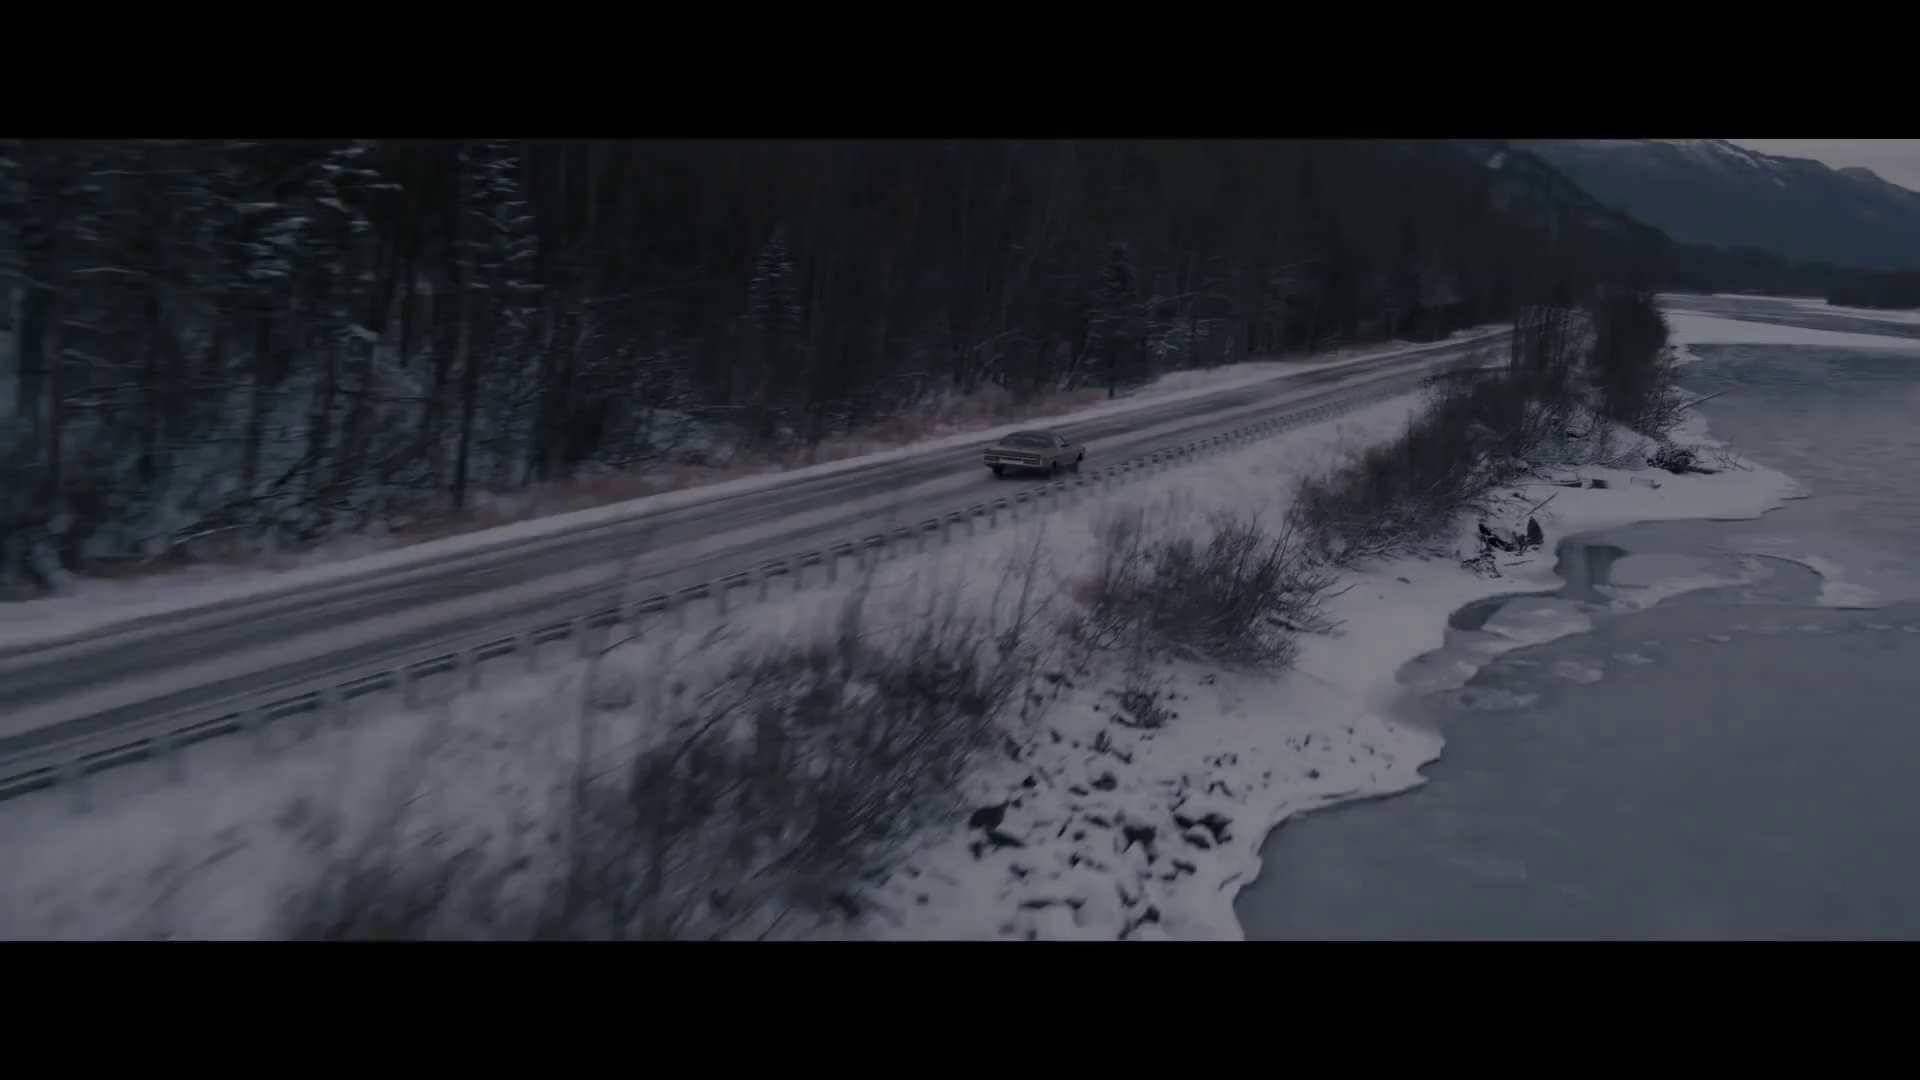

In [224]:
cv2_imshow(batches_Imgs[6][2])

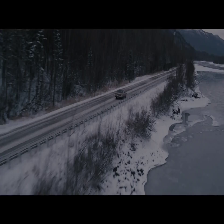

In [225]:
res = cv.resize(batches_Imgs[6][2], dsize=(224, 224), interpolation=cv.INTER_CUBIC)
cv2_imshow(res)

In [240]:
img = batches_Imgs[6][2]
print('original', img.shape)
img = cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
print('resize', img.shape)
img = img_to_array(img)
print('to_array', img.shape)
img = np.expand_dims(img, axis=0)
print('expand_dims', img.shape)
img = keras.applications.imagenet_utils.preprocess_input(img)
print('keras.preprocess', img.shape)

original (1080, 1920, 3)
resize (224, 224, 3)
to_array (224, 224, 3)
expand_dims (1, 224, 224, 3)
keras.preprocess (1, 224, 224, 3)


vstack (224, 224, 3)


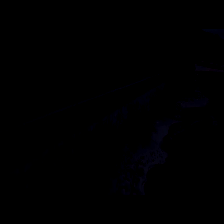

In [241]:
img = np.vstack(img)
print('vstack', img.shape)
cv2_imshow(img)

In [250]:
sc_labels = []
mv_labels = []

for root, _, files in os.walk('data/Videos/train'):
  for file in files:
    file = file.replace('.mp4','')
    shot_movement = file.split('_')[-1]
    shot = shot_movement.split(':')[0]
    movement = shot_movement.split(':')[1]
    sc_labels.append(shot)
    mv_labels.append(movement)
sc_labels

['FS',
 'ECS',
 'MS',
 'MS',
 'MS',
 'ECS',
 'CS',
 'ECS',
 'CS',
 'FS',
 'FS',
 'MS',
 'MS',
 'MS',
 'CS',
 'MS',
 'MS',
 'CS',
 'FS',
 'MS',
 'LS',
 'MS']

In [251]:
le = LabelEncoder()
enc_sc_labels = le.fit_transform(sc_labels)
for x,y in zip(sc_labels, enc_sc_labels):
  print(x, '-->', y)
print(f'Classes: {le.classes_}')

FS --> 2
ECS --> 1
MS --> 4
MS --> 4
MS --> 4
ECS --> 1
CS --> 0
ECS --> 1
CS --> 0
FS --> 2
FS --> 2
MS --> 4
MS --> 4
MS --> 4
CS --> 0
MS --> 4
MS --> 4
CS --> 0
FS --> 2
MS --> 4
LS --> 3
MS --> 4
Classes: ['CS' 'ECS' 'FS' 'LS' 'MS']


In [252]:
dicti = {}
for x,y in zip(sc_labels, enc_sc_labels):
  dicti.update({x:y})
dicti

{'CS': 0, 'ECS': 1, 'FS': 2, 'LS': 3, 'MS': 4}

In [256]:
dataset = HDF5DatasetWriter((n_imgs, 512*7*7), 'sample_data/features.hdf5',
                                dataKey='features', bufSize=3)

In [257]:
i = 0
datasetttt = 'data/Videos/train'
batch = 0
aux = 0
batchsizee = 3
imgs = []
batchImages = []
sc_labels = []
mv_labels = []

for root, _, files in os.walk(datasetttt):
    for file in files:
      file2 = file.replace('.mp4','')
      shot_movement = file2.split('_')[-1]
      shot = shot_movement.split(':')[0]
      movement = shot_movement.split(':')[1]
      sc_labels.append(shot)
      mv_labels.append(movement)

      video_full_path = os.path.join(root, file)
      cap = cv.VideoCapture(video_full_path)
      suc, frame = cap.read()
      image = cv.resize(frame, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
      image = img_to_array(image)
      image = np.expand_dims(image, axis=0)
      image = keras.applications.imagenet_utils.preprocess_input(image)
      if i < batchsizee:
          batchImages.append(image)
          print(filename, f'batch:{batch} ', f'img:{aux}', f'i:{i}', dicti[shot])
      else:
          batchImages = np.vstack(batchImages)
          features = model.predict(batchImages, batch_size=batchsizee)
          features = features.reshape((features.shape[0], 512*7*7))
          dataset.add(features, enc_sc_labels[aux-batchsizee:aux])
          print(f'label idx=[{aux-batchsizee}:{aux}]')
          print(f'Enc_labels={enc_sc_labels[aux-batchsizee:aux]}')
          print('####################################')
          batch += 1
          batchImages = []
          sc_labels = []
          mv_labels = []
          i = 0
          batchImages.append(image)
          print(filename, f'batch:{batch}', f'img:{aux}', f'i:{i}', dicti[shot])
      aux += 1
      i += 1

if batchImages is not None:
  rem_imgs = len(batchImages)
  print(rem_imgs)
  batchImages = np.vstack(batchImages)
  features = model.predict(batchImages, batch_size=batchsizee)
  features = features.reshape((features.shape[0], 512*7*7))
  print(f'label idx=[{-rem_imgs}:]')
  print(f'Enc_labels={enc_sc_labels[-rem_imgs:]}') 
  print('####################################')
  dataset.add(features, enc_sc_labels[-rem_imgs:])
  dataset.flush()

data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:0  img:0 i:0 2
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:0  img:1 i:1 1
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:0  img:2 i:2 4
label idx=[0:3]
Enc_labels=[2 1 4]
####################################
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:1 img:3 i:0 4
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:1  img:4 i:1 4
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:1  img:5 i:2 1
label idx=[3:6]
Enc_labels=[4 4 1]
####################################
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:2 img:6 i:0 0
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:2  img:7 i:1 1
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:2  img:8 i:2 0
label idx=[6:9]
Enc_labels=[0 1 0]
####################################
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch:3 img:9 i:0 2
data/Videos/train/tt2005374/shot_0011_MS:Motion.mp4 batch

In [100]:
# Double checking that labels are stored properly in order.
import h5py
file = 'sample_data/features.hdf5'
db = h5py.File(file)
list(db['labels'])

[2, 1, 4, 4, 4, 1, 0, 1, 0, 2, 2, 4, 4, 4, 0, 4, 4, 0, 2, 4, 3, 4]

In [ ]:
# Now, coding an end-to-end script

In [163]:
def get_labels(ds_path='data/Videos/train', sc_labels=[], mv_labels=[], n_imgs=0):
    print('Getting inferenced labels...')
    for root, _, files in os.walk(ds_path):
        for file in files:
            file = file.replace('.mp4','')
            shot_movement = file.split('_')[-1]
            shot = shot_movement.split(':')[0]
            movement = shot_movement.split(':')[1]
            sc_labels.append(shot)
            mv_labels.append(movement)
            n_imgs += 1
    return sc_labels, mv_labels, n_imgs

In [164]:
def model_database_prep(shotype='sc'):
    print('Loading network...')
    model = keras.applications.VGG16(weights='imagenet', include_top=False)

    sc_labels, mv_labels, n_imgs = get_labels()
    print('HDF5 Dataset init...')
    dataset = HDF5DatasetWriter((n_imgs, 512*7*7), 'sample_data/features.hdf5',
                                dataKey='features', bufSize=3)
    if shotype == 'sc':
        le = LabelEncoder()
        enc_sc_labels = le.fit_transform(sc_labels)
        # dataset.storeClassLabels(le.classes_)
        return model, dataset, enc_sc_labels
    if shotype == 'mv':
        le = LabelEncoder()
        enc_mv_labels = le.fit_transform(mv_labels)
        # dataset.storeClassLabels(le.classes_)
        return model, dataset, enc_mv_labels

In [166]:
def saliency(image, method='residual', show='False'):
    # load the input image
    # image = cv2.imread(image)
    if method == 'residual':
        saliency = cv.saliency.StaticSaliencySpectralResidual_create()
        (success, saliencyMap) = saliency.computeSaliency(image)
        print(success)
        saliencyMap = (saliencyMap * 255).astype("uint8")
        if not show == 'False':
            cv.imshow("Image", image)
            cv.imshow("Output", saliencyMap)
            cv.waitKey(0)
        return saliencyMap
    if method == 'finegrained':
        saliency = cv.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(image)
        saliencyMap = (saliencyMap * 255).astype("uint8")
        if not show == 'False':
            # show the images
            cv.imshow("Image", image)
            cv.imshow("Output", saliencyMap)
            cv.waitKey(0)
        return saliencyMap
    if method == 'fgthreshold':
        saliency = cv.saliency.StaticSaliencyFineGrained_create()
        (success, saliencyMap) = saliency.computeSaliency(image)
        saliencyMap = (saliencyMap * 255).astype("uint8")
        threshMap = cv.threshold(saliencyMap.astype("uint8"), 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
        if not show == 'False':
            # show the images
            cv.imshow("Image", image)
            cv.imshow("Thresh", threshMap)
            cv.waitKey(0)
        return threshMap
    if method == 'none':
        pass
    else:
        raise ValueError('Selected method is incorrect')

In [167]:
def extract_process_frame(root, file):
    video_full_path = os.path.join(root, file)
    cap = cv.VideoCapture(video_full_path)
    suc, frame = cap.read()
    image = cv.resize(frame, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
    # image = saliency(image, method='residual', show='False')
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = keras.applications.imagenet_utils.preprocess_input(image)
    return image

In [168]:
def video_processor(
    input_path='data/Videos/train', batchsize=32,
    i = 0, batch = 0, n_imgs = 0, batchImages = []
    ):
    model, dataset, enc_sc_labels = model_database_prep(shotype='sc')
    print('Processing images in batches...')
    for root, _, files in os.walk(input_path):
        for file in files:
            image = extract_process_frame(root, file)
            if i < batchsize:
                batchImages.append(image)
            else:
                batchImages = np.vstack(batchImages)
                features = model.predict(batchImages, batch_size=batchsize)
                features = features.reshape((features.shape[0], 512*7*7))
                dataset.add(features, enc_sc_labels[n_imgs-batchsize:n_imgs])
                batch += 1
                batchImages = []
                i = 0
                batchImages.append(image)
            n_imgs += 1
            i += 1

    if batchImages is not None:
        rem_imgs = len(batchImages)
        batchImages = np.vstack(batchImages)
        features = model.predict(batchImages, batch_size=batchsize)
        features = features.reshape((features.shape[0], 512*7*7))
        dataset.add(features, enc_sc_labels[-rem_imgs:])
        dataset.flush()
    print('Features already extracted and saved.')
    dataset.close()

In [169]:
video_processor()

Loading network...
Getting inferenced labels...
HDF5 Dataset init...
Processing images in batches...
Features already extracted and saved.


In [247]:
import h5py
file = 'sample_data/features.hdf5'
db = h5py.File(file)
imgprueba = list(db['features'][0])
print(f'Lenght of feature vector: {len(imgprueba)}')

Lenght of feature vector: 25088


In [212]:
# Reshaping feature vector as each one contains 512 flattened feature maps.
imgprueba = np.array(imgprueba)
imgprueba = np.reshape(imgprueba, (7,7,512))
imgprueba.shape

(7, 7, 512)

In [221]:
# Picking from Feature vector N° 0, the 150th feature map.
imgprueba2 = imgprueba[:,:,150]
image2 = cv.resize(imgprueba2, dsize=(224, 224), interpolation=cv.INTER_CUBIC)

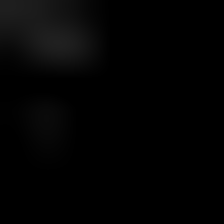

In [222]:
cv2_imshow(image2)

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(db['features'], db['labels'])

LogisticRegression()

In [259]:
# Just for doing an "end-to-end" circuit purposes.
preds = lr.predict(db['features'])
print(classification_report(db['labels'], preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00        10

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

